# <center/>Herding vs SBQ <center/>

Our figures for the BML project: Optimally-Weighted Herding is Bayesian Quadrature.

The scripts of the functions are in th Python files. This notabook is only meant for the display of our results.

_NB: Make sure to have the following modules:_ 
* numpy
* matplotlib
* scipy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Herding import *
from SBQ import *
from utils import GaussianMixture, GaussianKernel
from Plots import *

# Case of Gaussian Kernel

A natural distribution to study for this case is mixture of Gaussians.
The function to integrate against should be in the RKHS as to ensure that the errors have upper bound the MMD.

In [2]:
kernel = GaussianKernel(np.array([[1,0],[0,1]])*0.5**2)

## Parameters of Mixture

There is no constraint on the mixture $p$.

The goal is to compute: $\int f(x) p(x) dx$

The methods at hand is meant to sample from $p$

In [3]:
sigma = 0.5
mus = [[1.7644,1.0278],[2.2174,-2.722],[1.0073,-0.9821],[2.1473,0.2475],[-1.9556,-3.5406],[-1.0021,3.2158],[0.9342,-0.5304],[-3.7110,-2.5693],[3.8438,-3.1127],[2.8168,-3.2514],[-3.0731,2.7305],[0.228,-2.8512],[-1.9643,-1.0489],[-1.3097,-2.8430],[-3.3647,0.795],[1.3437,-1.0198],[2.1017,-0.5647],[-1.7266,-1.7964],[-0.8518,1.4021],[2.9369,-3.3802]]
sigmas = [
    [[0.1727,0.0043],[0.0043,0.1063]],
    [[0.2909,-0.0007],[-0.0007,0.2671]],
    [[3.0541,2.3127],[2.3127,1.8809]],
    [[0.2046,0.1296],[0.1296,0.1936]],
    [[0.2325,0.3529],[0.3529,1.3044]],
    [[0.1734,-0.0208],[-0.0208,0.0712]],
    [[0.6385,0.1571],[0.1571,0.1055]],
    [[0.8177,0.5617],[0.5617,0.6469]],
    [[1.0715,0.6782],[0.6782,0.5498]],
    [[0.4471,-0.1659],[-0.1659,0.5147]],
    [[0.2294,-0.0006],[-0.0006,0.0672]],
    [[0.0842,-0.006],[-0.006,0.0672]],
    [[0.4279,0.025],[0.025,0.2014]],
    [[0.2681,0.0328],[0.0328,0.3009]],
    [[0.2463,-0.0739],[-0.0739,0.1261]],
    [[0.8137,0.4627],[0.4627,0.4359]],
    [[2.1496,1.2296],[1.2296,1.9657]],
    [[0.5496,-0.1593],[-0.1593,0.1295]],
    [[0.2417,0.1835],[0.1835,0.6737]],
    [[0.5981,0.3097],[0.3097,0.4669]]
]
p = [0.0508,0.0537,0.0343,0.0393,0.0452,0.0518,0.0285,0.0676,0.0354,0.053,0.0575,0.0527,0.0461,0.0614,0.0424,0.0532,0.0605,0.0457,0.0593,0.0614]

mus = np.array(mus)
sigmas = np.array(sigmas)

gm = GaussianMixture(p,mus,sigmas)
mean = np.sum([p[k] * mus[k] for k in range(len(p))])

# gaussian mixture area within the plot
area = np.array([np.min(gm.means, axis=0)-1.5, np.max(gm.means, axis=0)+1.5])

# <center>Herding</center>

In [4]:
samplesH = herding(100,kernel,gm,area=area,samples=[])

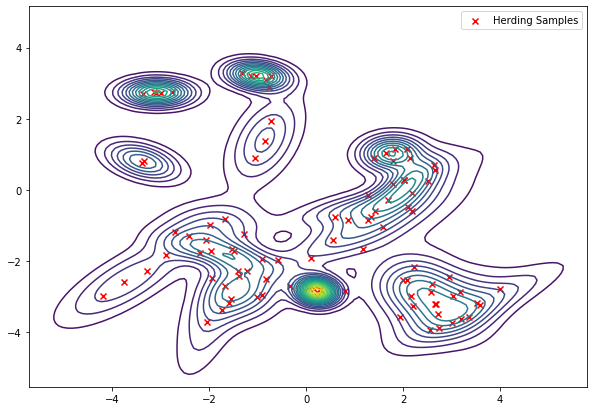

In [5]:
plotContour(gm,samplesH)

# <center>SBQ</center>

In [6]:
# samplesSBQ, gram, z = SBQ(100,kernel,gm,area,samples=[])
samplesSBQ = np.loadtxt('samplesSBQ.csv', delimiter=',')

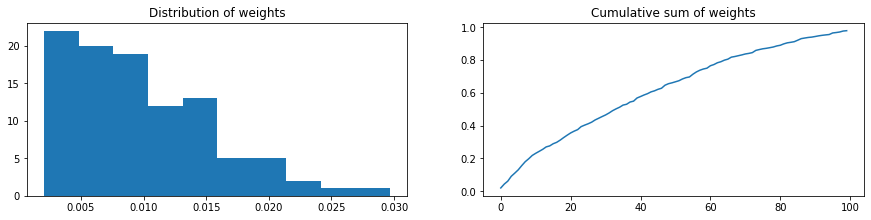

In [7]:
plotSBQweights(samplesSBQ, gm, kernel)

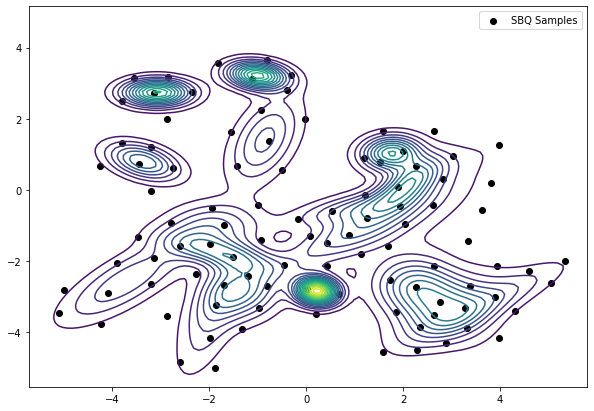

In [8]:
plotContour(gm, samplesSBQ=samplesSBQ)

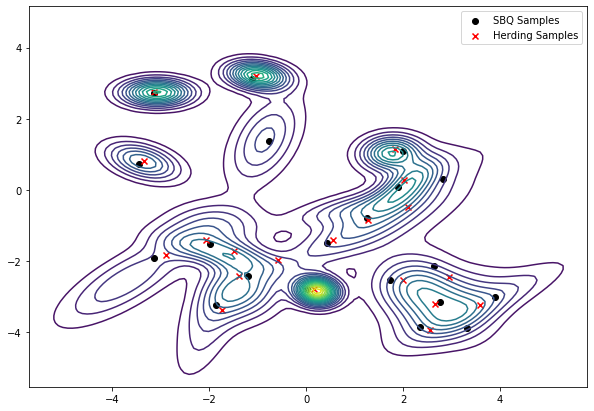

In [9]:
plotContour(gm, samplesH[:20], samplesSBQ[:20])

# MMD



In [10]:
samplesIID = area[None, 0] + (area[None, 1] - area[None, 0]) * np.random.rand(100, 2)

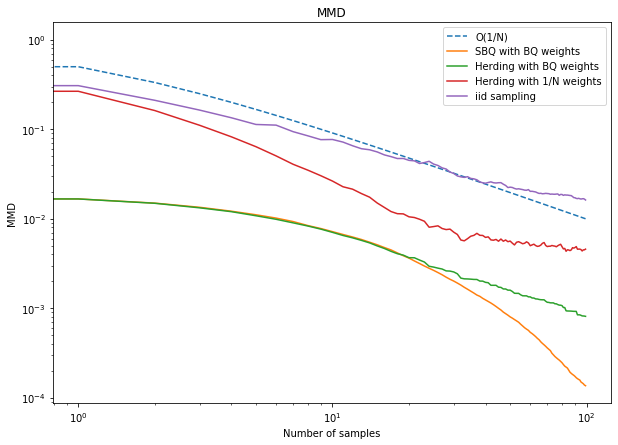

In [11]:
plotMMD(samplesSBQ, samplesH, samplesIID, gm, kernel)

## Errors


We first generate functions in the RKHS with reproducing kernel $k$.

In [12]:
funcs, targets = generateRKHSFunc(250, kernel, gm)

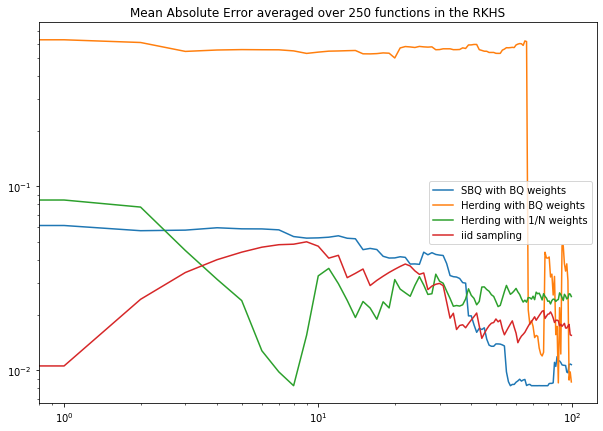

In [13]:
plotErrors(samplesH, samplesSBQ, samplesIID, gm, kernel, funcs, targets)

In [17]:
# plot herding does not look like
nfuncs = 250
error = 0
N = 20
for _ in range(nfuncs):
    beta = 10 * (np.random.rand(N) + 1)
    c = 4 * 2 * (np.random.rand(N, 2) - 1/2)   # mean for kernel 
    factor = 0
    for k in range(N):
        for l in range(N):
            factor += beta[k] * beta[l] * kernel.pdf(c[k], c[l])
    beta /= (factor)**(1/2)                # in the unit ball the RKHS
    f = lambda x : np.sum([beta[i] * kernel.pdf(x, c[i]) for i in range(len(beta))], axis=0)
    target = targetRKHS(beta, c, kernel, gm)
    error += np.abs(np.cumsum(f(samplesH)) / np.arange(1, len(samplesH)+1) - target[None])
error /= nfuncs

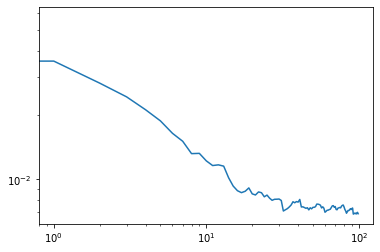

In [19]:
plt.plot(error)
plt.xscale('log')
plt.yscale('log')